# Domain adaptation with OT

#### Comparison between the main implementation in POT, and regDROT for Group-Lasso

First we import the necessarily libraries, and define some ancillary functions.

In [23]:
from npdrot import l1l2drot
from sklearn.datasets import make_moons
from ot.da import sinkhorn_l1l2_gl

import numpy as np
import matplotlib.pyplot as plt

In [24]:
def dist_matrix(X1, X2, as_fortran=False):
    c1 = np.linalg.norm(X1, axis=1) ** 2
    c2 = np.linalg.norm(X2, axis=1) ** 2

    C = - X1 @ X2.T 
    C += c1.reshape(-1, 1) / 2
    C += c2.reshape(1, -1) / 2
        
    if as_fortran:
        return np.asfortranarray(C, dtype=np.float64)
    else:
        return C
    
def gen_group_list(num_labels, num_instances):
    num_instances_per_label = num_instances // num_labels
    return [(i*num_instances_per_label, (i+1)*num_instances_per_label) for i in range(num_labels)]
    
def adapt_source_domain(Xt, transportation_plan, p):
    scale = transportation_plan.sum(axis=1)
    scale += p
    scale /= 2
    
    np.nan_to_num(scale, 1/transportation_plan.shape[0])
    return transportation_plan @ Xt / scale.reshape(-1, 1)

def make_moon_dataset(num_instances, seed=None, std=0.1):
    Xs, ys = make_moons(n_samples=num_instances, shuffle=False, random_state=seed, noise=std)
    
    # Generate random transformation
    dim = 2
    np.random.seed(seed)
    k = 5
    n_rows_A = min([k, dim])
    A = np.random.normal(size=(n_rows_A, dim))
    transform = A.T @ A / n_rows_A
    
    # Weight it towards identity operator for stability
    alpha = 0.1
    transform = alpha*np.eye(dim) + (1-alpha)*transform


    Xt = Xs @ transform
    
    # Generate random translation
    translation = 3*np.random.normal(size=(1, dim))

    Xt += translation
    
    return Xs, ys, Xt, np.copy(ys)

## Simulation of data set

We will use a "moon dataset" in 2d, in which the classes have rotated, stretched, and translated.

In [25]:
n_labels = 2
n_instances = 500
seed = 2493078133

Xs, ys, Xt, yt = make_moon_dataset(n_instances, seed, std=0.1)

# Equal weight of each sample
p = np.ones(ys.shape) / len(ys)
q = np.ones(yt.shape) / len(yt)

groups = gen_group_list(n_labels, n_instances)

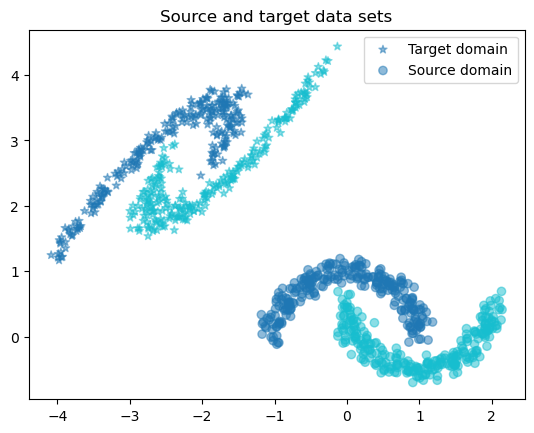

In [26]:
_, ax = plt.subplots(1, sharex=True, sharey=True)
ax.scatter(Xt[:,0], Xt[:,1], marker='*', c=yt,alpha=0.5, cmap='tab10', label='Target domain')
ax.scatter(Xs[:,0], Xs[:,1], c=ys, alpha=0.5,cmap='tab10', label='Source domain')
ax.set_title("Source and target data sets")
_ = ax.legend()

## Computing transportation plans

In order to use OT for domain adaptation, we need the pairwise distances of the pointclouds. The resulting cost matrices are then normalized.

In [27]:
Cft = dist_matrix(Xs, Xt, as_fortran=True)
C = dist_matrix(Xs, Xt)

C /=C.max()
Cft /=Cft.max()

In [28]:
reg=0.01
reg_entr = 0.005

And to get an idea of the computational performance, we do a quick benchmark with `%timeit`

In [29]:
%timeit l1l2drot(np.outer(p, q), Cft, p, q, reg, groups, numba=True,  max_iters=5000, compute_r_primal=True, compute_r_dual=False, eps_abs=1e-4)

730 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit sinkhorn_l1l2_gl(p, ys, q, C, eta=reg, reg=reg_entr, numItermax=5000)

2.99 s ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Observations reveal that when comparing the CPU version, specific hyperparameter configurations can result in faster execution times for the `sinkhorn_l1l2_gl` implementation compared to the `l1l2drot` implementation of regDROT. However, it is important to note that this speedup often comes at the cost of compromised quality in the transportation plans, which is illustrated next.

**Side-note**: With that, as shown in other examples, `l1l2drot` can more effectively benefit from the GPU parallelization than `sinkhorn_l1l2_gl`.

## Using the estimated transportation plans for DA

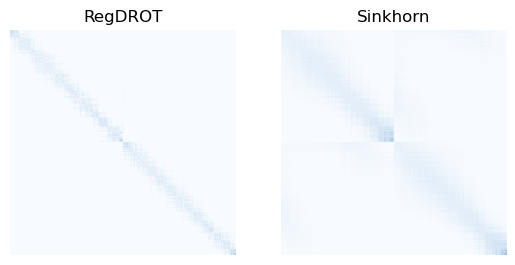

In [31]:
gamma_drot, log = l1l2drot(np.outer(p, q), Cft, p, q, reg, groups, numba=True,  max_iters=5000, compute_r_primal=True, compute_r_dual=False, eps_abs=1e-4, return_log=True)
gamma_sk = sinkhorn_l1l2_gl(p, ys, q, C, reg=reg, eta=reg_entr, numItermax=5000)

fig, ax = plt.subplots(1,2)

ax[0].imshow(gamma_drot, cmap='Blues')
ax[1].imshow(gamma_sk, cmap='Blues')

_ = ax[0].set_title("RegDROT")
_ = ax[1].set_title("Sinkhorn")

_ = ax[0].axis("off")
_ = ax[1].axis("off")

Both the `sinkhorn_l1l2_gl` and `l1l2drot` implementations successfully identify the block structure of the solution by utilizing labels. As anticipated, the application of entropic regularization in the transportation plans leads to a blurrier outcome. This blurriness, in turn, has a noticeable impact on the adaptation process, which we demonstrate below.

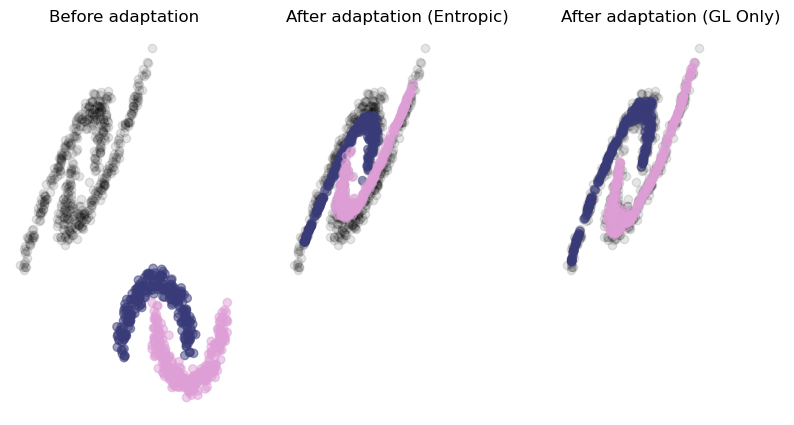

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

Xs_adapt_drot = adapt_source_domain(Xt, gamma_drot, p)
Xs_adapt_sk = adapt_source_domain(Xt, gamma_sk, p)

ax[0].scatter(Xt[:,0], Xt[:,1], marker='o', alpha=0.1, c='k', cmap='tab20b', label='Target domain')
ax[0].scatter(Xs[:,0], Xs[:,1], marker='o', alpha=0.5, c=ys, cmap='tab20b',label='Source domain')
ax[0].axis('off')
ax[0].set_title('Before adaptation', size=12)

xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

ax[1].scatter(Xt[:,0], Xt[:,1], marker='o', alpha=0.1, c='k', cmap='tab20b', label='Target domain')
ax[1].scatter(Xs_adapt_sk[:,0], Xs_adapt_sk[:,1], marker='o', alpha=0.5, c=ys, cmap='tab20b', label='Adapted domain')
ax[1].axis('off')
ax[1].set_title('After adaptation (Entropic)', size=12)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

ax[2].scatter(Xt[:,0], Xt[:,1], marker='o', alpha=0.1, c='k', cmap='tab20b', label='Target domain')
ax[2].scatter(Xs_adapt_drot[:,0], Xs_adapt_drot[:,1], marker='o', alpha=0.5, c=ys, cmap='tab20b', label='Adapted domain')

ax[2].axis('off')

ax[2].set_title('After adaptation (GL Only)', size=12)

ax[2].set_xlim(xlim)
_= ax[2].set_ylim(ylim)
